In [60]:
%pip install torch torchvision pillow opencv-python numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [61]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ast # For safe evaluation
import random
import os
import random
import numpy as np

In [62]:
# Define the CNN architecture (must be the same as during training)
class CharacterRecognizerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterRecognizerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1_input_size = 128 * (45 // (2**3)) * (45 // (2**3)) # Assuming img_size = 45
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

        self.img_size = 45

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.fc1_input_size)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the class names (important for mapping predictions back to characters)
data_dir = './Dataset/Dataset' # Adjust if needed
train_dir = os.path.join(data_dir, 'train')
train_dataset = datasets.ImageFolder(train_dir) # No transform needed here
class_names = train_dataset.classes
num_classes = len(class_names)

# Load the trained model
model = CharacterRecognizerCNN(num_classes)
model.load_state_dict(torch.load('./character_recognizer.pth', map_location=torch.device('cpu')))

model.eval() # Set the model to evaluation mode for inference

device = torch.device("cpu")
model.to(device)

print("Trained model loaded.")
print(f"Class names: {class_names}")

Trained model loaded.
Class names: ['decimal', 'divide', 'eight', 'equal', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']


In [63]:
def equation_generator(numbers=2, max_num=101):
    assert numbers > 1, "You need at least two numbers to generate a valid equation"
    # Generate numbers and operators
    generated_eqn = []
    operators = ['+', '-', '*', '/'] # Include division
    for _ in range(numbers):
        gen_num = np.random.randint(1, max_num + 1) # Avoid zero for division simplicity
        generated_eqn.append(str(gen_num))
        if _ < numbers - 1:
            operator = random.choice(operators)
            generated_eqn.append(operator)
    # Turn into string
    generated_eqn_str = ''.join(generated_eqn)
    try:
        ans = eval(generated_eqn_str)
        ans_string = '=' + str(ans)
        return generated_eqn_str + ans_string
    except ZeroDivisionError:
        return equation_generator(numbers, max_num) # Regenerate if division by zero occurs
    except Exception as e:
        print(f"Error evaluating equation: {generated_eqn_str} - {e}")
        return None # Or handle the error as you see fit

# Generate a test equation
test_equation_with_answer = equation_generator(numbers=3, max_num=10)
print(f"Generated test equation: {test_equation_with_answer}")

Generated test equation: 8*1+10=18


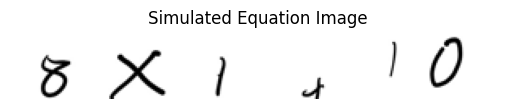

In [64]:
import random
from PIL import Image

def random_sample_file(directory):
    # Randomly selects a file from a directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if not files:
        return None
    return os.path.join(directory, random.choice(files))

def generate_equation_image(equation_string, character_folder_path, target_height=45, crop_bottom_percent=0.1): # Added crop_bottom_percent
    digit_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine'
    }
    image_list = []
    for char in equation_string:
        if char in digit_map:
            char_folder = os.path.join(character_folder_path, digit_map[char])
        elif char == '*':
            char_folder = os.path.join(character_folder_path, 'times')
        elif char == '/':
            char_folder = os.path.join(character_folder_path, 'divide')
        elif char == '+':
            char_folder = os.path.join(character_folder_path, 'plus')
        elif char == '-':
            char_folder = os.path.join(character_folder_path, 'minus')
        elif char == '=':
            char_folder = os.path.join(character_folder_path, 'equal')
        elif char == '.':
            char_folder = os.path.join(character_folder_path, 'decimal')
        else:
            print(f"Warning: Unknown character '{char}' in equation")
            continue

        image_file = random_sample_file(char_folder)
        if image_file:
            img = Image.open(image_file).convert('L') # Open as grayscale
            # Resize to target height while maintaining aspect ratio
            aspect_ratio = img.width / img.height
            new_width = int(target_height * aspect_ratio)
            img = img.resize((new_width, target_height))

            # Crop from the bottom
            crop_pixels = int(target_height * crop_bottom_percent)
            img = img.crop((0, 0, img.width, img.height - crop_pixels))

            image_list.append(img)
        else:
            print(f"Warning: No image found for character '{char}' in '{char_folder}'")
            return None

    if not image_list:
        return None

    # Concatenate images horizontally
    total_width = sum(img.width for img in image_list)
    max_height = max(img.height for img in image_list)
    combined_image = Image.new('L', (total_width, max_height), color=255) # White background

    x_offset = 0
    for img in image_list:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined_image

# Example usage (you can adjust crop_bottom_percent if needed):
character_dataset_path = './Dataset/Dataset/train' # Adjust this to your training data path
if test_equation_with_answer:
    equation_image = generate_equation_image(test_equation_with_answer.split('=')[0], character_dataset_path, crop_bottom_percent=0.1) # Crop 10% from the bottom
    if equation_image:
        plt.imshow(equation_image, cmap='gray')
        plt.title("Simulated Equation Image")
        plt.axis('off')
        plt.show()

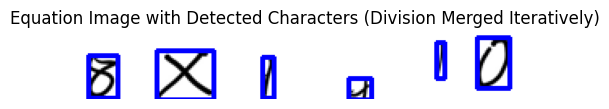

Detected 6 character regions


In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Make sure this is imported

def is_fully_within_x(inner_rect, outer_rect):
    """Checks if the x-range of inner_rect is fully within outer_rect."""
    inner_x_start, _, inner_width, _ = inner_rect
    outer_x_start, _, outer_width, _ = outer_rect
    return outer_x_start <= inner_x_start and (inner_x_start + inner_width) <= (outer_x_start + outer_width)

def merge_rects(rect1, rect2):
    """Merges two bounding boxes into one."""
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y
    return (new_x, new_y, new_w, new_h)

def detect_contours_and_merge_division(image):
    # Convert PIL Image to OpenCV format (NumPy array)
    open_cv_image = np.array(image)
    # Convert RGB to grayscale if it's a color image
    if len(open_cv_image.shape) == 3:
        gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = open_cv_image

    # Binarize the image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get initial bounding boxes
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    if not rects:
        return []

    # Sort bounding boxes by x-coordinate
    rects.sort(key=lambda x: x[0])

    merged = True
    while merged:
        merged = False
        new_rects = []
        n = len(rects)
        merged_indices = [False] * n
        for i in range(n):
            if not merged_indices[i]:
                current_rect = rects[i]
                for j in range(i + 1, n):
                    if not merged_indices[j]:
                        other_rect = rects[j]
                        if is_fully_within_x(current_rect, other_rect) or is_fully_within_x(other_rect, current_rect):
                            current_rect = merge_rects(current_rect, other_rect)
                            merged_indices[i] = True
                            merged_indices[j] = True
                            merged = True
                new_rects.append(current_rect)
        rects = new_rects

    # Filter out very small boxes (potential noise)
    min_area = 20
    filtered_rects = [(x, y, w, h) for x, y, w, h in rects if w * h > min_area]
    return filtered_rects

# Example usage (assuming 'equation_image' is a PIL Image object):
if 'equation_image' in locals():
    bounding_boxes = detect_contours_and_merge_division(equation_image)

    # Draw bounding boxes on the image for visualization
    image_with_boxes = np.array(equation_image).copy()
    if len(image_with_boxes.shape) == 2:
        image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_GRAY2BGR)
    else:
        image_with_boxes = image_with_boxes.copy()

    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 0, 255), 2) # Red boxes

    plt.imshow(image_with_boxes)
    plt.title("Equation Image with Detected Characters (Division Merged Iteratively)")
    plt.axis('off')
    plt.show()

    print(f"Detected {len(bounding_boxes)} character regions")
else:
    print("Please load 'equation_image' (a PIL Image object) to run the example.")

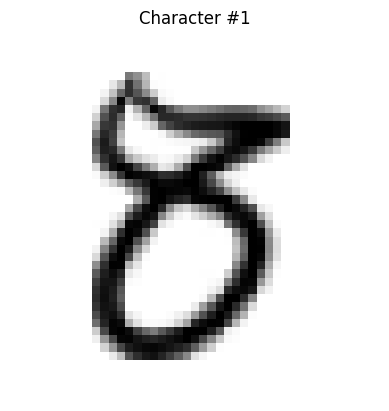

Recognized: 8


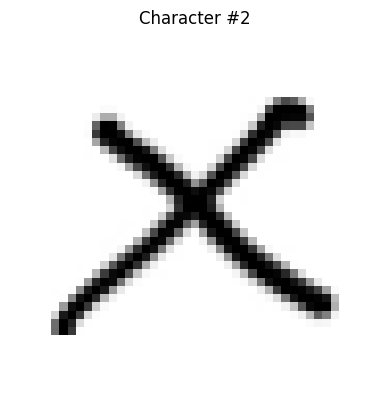

Recognized: *


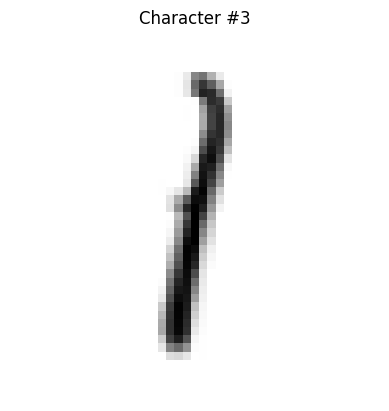

Recognized: 1


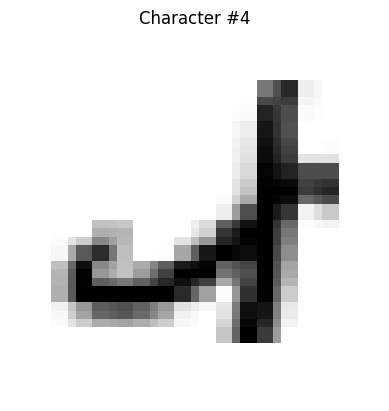

Recognized: 6


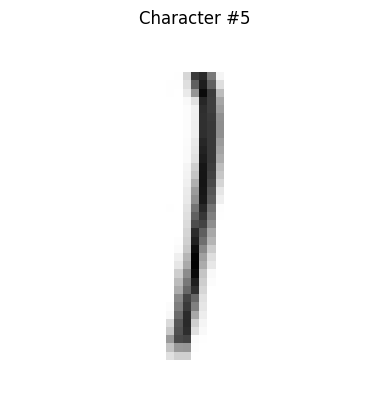

Recognized: 1


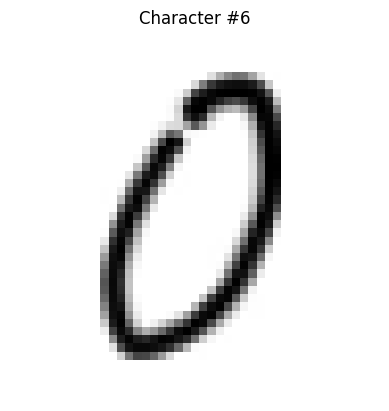

Recognized: 0

Recognized Equation: 8*1610

Solution: 12880


In [66]:
import matplotlib.pyplot as plt
# Add the new preprocess_symbol function here
def preprocess_symbol(char_roi, target_size=(45, 45), padding=5):
    """
    Preprocess a single character image with aspect-ratio-preserving resize and padding.
    """
    if char_roi.size == 0:
        raise ValueError("Empty ROI passed to preprocess_symbol.")

    # Create a white background image
    background = np.ones((target_size[0], target_size[1]), dtype=np.uint8) * 255

    h, w = char_roi.shape[:2]
    if h == 0 or w == 0:
        raise ValueError(f"Invalid character ROI size: height={h}, width={w}")

    aspect_ratio = w / h
    max_dim = max(target_size) - (padding * 2)

    if aspect_ratio > 1:
        new_width = max(1, int(max_dim))
        new_height = max(1, int(new_width / aspect_ratio))
    else:
        new_height = max(1, int(max_dim))
        new_width = max(1, int(new_height * aspect_ratio))

    resized_char = cv2.resize(char_roi, (new_width, new_height), interpolation=cv2.INTER_AREA)

    x_offset = (target_size[1] - new_width) // 2
    y_offset = (target_size[0] - new_height) // 2

    background[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_char

    return background


# Mapping from class names to readable characters
symbol_map = {
    "plus": "+",
    "minus": "-",
    "times": "*",
    "divide": "/",
    "equals": "=",
    "decimal": ".",
    "one": "1",
    "two": "2",
    "three": "3",
    "four": "4",
    "five": "5",
    "six": "6",
    "seven": "7",
    "eight": "8",
    "nine": "9",
    "zero": "0",
    # Add more if needed
}

# Define the transformations - MODIFY THIS PART to remove the resize step
recognition_transforms = transforms.Compose([
    # Removed the resize step since we're handling it in preprocess_symbol
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

recognized_characters = []
if equation_image and bounding_boxes:
    open_cv_image = np.array(equation_image)
    if len(open_cv_image.shape) == 3:
        open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    for i, (x, y, w, h) in enumerate(sorted(bounding_boxes, key=lambda i: i[0])):
        char_roi = open_cv_image[y:y + h, x:x + w]
        
        # Process the character while maintaining aspect ratio - ADD THIS LINE
        processed_char = preprocess_symbol(char_roi)
        
        # Convert to PIL image - MODIFY THIS LINE
        char_pil = Image.fromarray(processed_char)
        
        # Show the processed character image
        plt.imshow(char_pil, cmap='gray')
        plt.title(f"Character #{i + 1}")
        plt.axis('off')
        plt.show()
        
        # Transform and predict with the processed character
        input_tensor = recognition_transforms(char_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_idx = torch.max(output, 1)
            predicted_label = class_names[predicted_idx[0]]
            readable_char = symbol_map.get(predicted_label, predicted_label)
            recognized_characters.append(readable_char)
            print(f"Recognized: {readable_char}")

    recognized_equation = "".join(recognized_characters)
    print(f"\nRecognized Equation: {recognized_equation}")
    print(f"\nSolution: {eval(recognized_equation)}")
else:
    print("No equation image or bounding boxes found.")


📷 Press 's' to capture equation | 'q' to quit

🖼️ Captured frame. Processing...
Found 9 raw contours. Drawing all below:
  Raw Contour #0: Box=(36,296,49,53), Area=2597
  Raw Contour #1: Box=(166,295,10,9), Area=90
  Raw Contour #2: Box=(327,57,41,94), Area=3854
  Raw Contour #3: Box=(341,179,43,70), Area=3010
  Raw Contour #4: Box=(411,67,45,71), Area=3195
  Raw Contour #5: Box=(424,181,51,42), Area=2142
  Raw Contour #6: Box=(495,61,49,68), Area=3332
  Raw Contour #7: Box=(515,198,39,6), Area=234
  Raw Contour #8: Box=(574,63,53,73), Area=3869
--- Filtering Contours ---
  Filtering Contour #0: Box=(36,296,49,53), Area=2597, AR=0.92 -> ACCEPTED
  Filtering Contour #1: Box=(166,295,10,9), Area=90, AR=1.11 -> ACCEPTED
  Filtering Contour #2: Box=(327,57,41,94), Area=3854, AR=0.44 -> ACCEPTED
  Filtering Contour #3: Box=(341,179,43,70), Area=3010, AR=0.61 -> ACCEPTED
  Filtering Contour #4: Box=(411,67,45,71), Area=3195, AR=0.63 -> ACCEPTED
  Filtering Contour #5: Box=(424,181,51,42), Ar

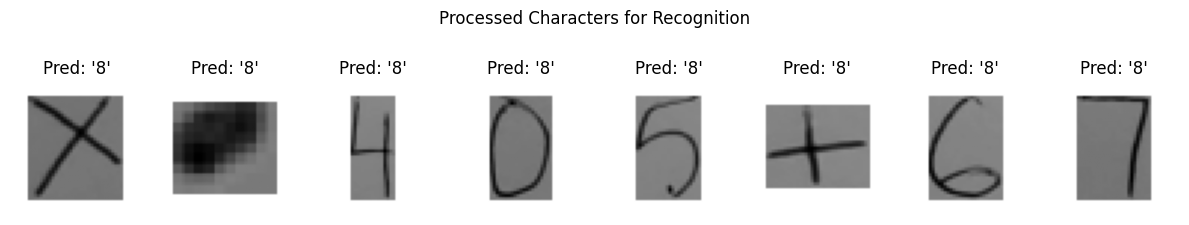


🧠 Recognized Equation: 88888888
✅ Result: 88888888
👋 Quitting...


In [67]:
# %%
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch # Make sure torch is imported if not already done globally
# Assume model, device, recognition_transforms, preprocess_symbol, class_names, symbol_map are defined above

# --- MODIFIED detect_contours_and_merge_division ---
def is_fully_within_x(inner_rect, outer_rect):
    """Checks if the x-range of inner_rect is fully within outer_rect."""
    inner_x_start, _, inner_width, _ = inner_rect
    outer_x_start, _, outer_width, _ = outer_rect
    return outer_x_start <= inner_x_start and (inner_x_start + inner_width) <= (outer_x_start + outer_width)

def merge_rects(rect1, rect2):
    """Merges two bounding boxes into one."""
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y
    return (new_x, new_y, new_w, new_h)

def detect_contours_and_merge_division(image):
    # Convert PIL Image to OpenCV format (NumPy array)
    open_cv_image = np.array(image)
    # Convert RGB to grayscale if it's a color image
    if len(open_cv_image.shape) == 3:
        gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = open_cv_image

    # Binarize the image - ** ADJUST PARAMETERS AS NEEDED **
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 4) # Example: Tuned parameters

    cv2.imshow("1 - Thresholded", thresh)

    # --- ADDED: Morphological Opening ---
    kernel = np.ones((2,2), np.uint8) # Kernel size (tune if needed: (3,3), etc.)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    # --- Find contours on the 'opening' image ---
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    cv2.imshow("2 - Opening Result", opening)
    cv2.waitKey(1) # Allow windows to display


    # Get initial bounding boxes
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    if not rects:
        return []

    # Sort bounding boxes by x-coordinate
    rects.sort(key=lambda x: x[0])

    # --- (Optional Division Merging Logic - kept from original) ---
    merged = True
    while merged:
        merged = False
        new_rects = []
        n = len(rects)
        merged_indices = [False] * n
        for i in range(n):
            if not merged_indices[i]:
                current_rect = rects[i]
                # Note: This merging might need adjustment depending on how division appears
                for j in range(i + 1, n):
                    if not merged_indices[j]:
                        other_rect = rects[j]
                        # Simple vertical check for division components (adjust logic if needed)
                        if abs(current_rect[0] - other_rect[0]) < max(current_rect[2], other_rect[2]) / 2 : # X overlap check
                           if is_fully_within_x(current_rect, other_rect) or is_fully_within_x(other_rect, current_rect): # Added stricter check
                                current_rect = merge_rects(current_rect, other_rect)
                                merged_indices[i] = True # Mark both as merged
                                merged_indices[j] = True
                                merged = True
                                break # Merge only one pair per pass for simplicity here
                if not merged_indices[i]: # Add only if not merged in this pass
                   new_rects.append(current_rect)

        # Add any remaining unmerged rects from the end
        for i in range(n):
             if not merged_indices[i] and rects[i] not in new_rects:
                  new_rects.append(rects[i])

        if merged: # Only update if a merge happened
             rects = sorted(new_rects, key=lambda x: x[0]) # Re-sort after merging
        else:
             break # Exit loop if no merges in a pass


    # Note: Area filtering is now done in the main loop
    return rects

# --- MODIFIED WEBCAM LOOP ---

cap = cv2.VideoCapture(0)
print("📷 Press 's' to capture equation | 'q' to quit")

# --- Filter Parameters (Tune these based on output!) ---
min_area = 30          # Minimum pixel area
max_chars = 20         # Max characters to process
min_aspect_ratio = 0.05 # Minimum width/height ratio
max_aspect_ratio = 2.0  # Maximum width/height ratio
min_height = 8         # Minimum pixel height
min_width = 4          # Minimum pixel width

# --- Font for drawing contour numbers ---
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (255, 0, 0) # Blue color for text
line_type = 1

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to grab frame.")
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow("Live Feed (Grayscale)", gray_frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('s'):
        print("\n🖼️ Captured frame. Processing...")
        pil_img = Image.fromarray(gray_frame)

        # Use the modified detection function
        raw_boxes = detect_contours_and_merge_division(pil_img)

        # --- ADDED: Visualize ALL Raw Contours ---
        raw_contours_img = frame.copy() # Create a copy to draw raw contours on
        print(f"Found {len(raw_boxes)} raw contours. Drawing all below:")
        for i, (x, y, w, h) in enumerate(raw_boxes):
            # Draw rectangle for the raw contour
            cv2.rectangle(raw_contours_img, (x, y), (x + w, y + h), (0, 0, 255), 1) # RED thin rectangle for RAW
            # Put text label (contour index) near the box
            label_position = (x, y - 5) # Position text slightly above the top-left corner
            cv2.putText(raw_contours_img, f"#{i}", label_position, font, font_scale, font_color, line_type)
            # Print info to console as well
            print(f"  Raw Contour #{i}: Box=({x},{y},{w},{h}), Area={w*h}")

        # Display the image with ALL raw contours drawn
        cv2.imshow("All Raw Contours Detected", raw_contours_img)
        cv2.waitKey(1) # Make sure the window updates
        # --- END Raw Contour Visualization ---


        # --- Existing Filtering Logic (with debug prints) ---
        filtered_boxes = []
        print("--- Filtering Contours ---")
        for i, (x, y, w, h) in enumerate(raw_boxes): # Iterate through raw_boxes again for filtering
            area = w * h
            print(f"  Filtering Contour #{i}: Box=({x},{y},{w},{h}), Area={area}", end='') # Print initial info

            if area < min_area:
                print(f" -> REJECTED (Area < {min_area})")
                continue # Skip small contours

            if h < min_height or w < min_width:
                print(f" -> REJECTED (H:{h}<{min_height} or W:{w}<{min_width})")
                continue # Skip too small dimensions

            aspect_ratio = w / h if h > 0 else 0 # Calculate aspect ratio safely
            print(f", AR={aspect_ratio:.2f}", end='') # Print aspect ratio

            if h == 0 or aspect_ratio < min_aspect_ratio or aspect_ratio > max_aspect_ratio:
                 print(f" -> REJECTED (AR out of range [{min_aspect_ratio:.2f}-{max_aspect_ratio:.2f}])")
                 continue # Skip contours with unlikely aspect ratios

            # If it passes all filters:
            print(" -> ACCEPTED")
            filtered_boxes.append((x, y, w, h))
        print("--- Filtering Done ---")
        # --- END Filtering Logic ---

        # Sort the *filtered* boxes by x-coordinate and limit count
        boxes = sorted(filtered_boxes, key=lambda b: b[0])[:max_chars]
        print(f"Filtered down to {len(boxes)} character candidates.")

        if not boxes:
             print("⚠️ No valid character contours detected after filtering.")
             # Keep the raw contour window open, maybe show an empty "Detected" window
             empty_detect_img = frame.copy()
             cv2.putText(empty_detect_img, "No Chars Accepted", (50, 50), font, 1, (0,0,255), 2)
             cv2.imshow("Detected Characters", empty_detect_img)
             cv2.waitKey(1)
             continue # Skip processing if no boxes left

        # --- Recognition and Plotting Logic (using the filtered 'boxes') ---
        debug_img = frame.copy() # Use a fresh copy for drawing accepted boxes
        recognized_chars = []
        gray_np = np.array(pil_img)

        # Prepare plot (ensure it handles zero boxes case if needed, though we check above)
        if len(boxes) > 0:
             fig, axes = plt.subplots(1, len(boxes), figsize=(1.5 * len(boxes), 2.5))
             if len(boxes) == 1:
                 axes = [axes] # Ensure axes is iterable even with one box
             fig.suptitle("Processed Characters for Recognition")
        else: # Should not happen due to check above, but as safeguard
             axes = []


        for idx, (x, y, w, h) in enumerate(boxes): # Iterate through ACCEPTED boxes
            # Draw GREEN rectangle for accepted boxes on a separate debug image
            cv2.rectangle(debug_img, (x, y), (x + w, y + h), (0, 255, 0), 2) # GREEN thick rectangle

            # --- Existing ROI extraction, preprocessing, prediction ---
            roi = gray_np[y:y+h, x:x+w]
            if roi.size == 0 or h <= 0 or w <= 0:
                 # ... (error handling as before) ...
                 print(f"Warning: Skipping invalid ROI for accepted box #{idx+1} {(x,y,w,h)}")
                 recognized_chars.append('?')
                 if idx < len(axes): axes[idx].set_title(f"? (Invalid ROI)"); axes[idx].axis('off')
                 continue
            try:
                processed = preprocess_symbol(roi)
                char_img = Image.fromarray(processed)
            except ValueError as e:
                 # ... (error handling as before) ...
                 print(f"Error preprocessing accepted box #{idx+1} {(x,y,w,h)}: {e}")
                 recognized_chars.append('?')
                 if idx < len(axes): axes[idx].set_title(f"? (Error)"); axes[idx].axis('off')
                 continue

            input_tensor = recognition_transforms(char_img).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                _, pred_idx = torch.max(output, 1)
                label = class_names[pred_idx[0]]
                char = symbol_map.get(label, label)
                recognized_chars.append(char)
                print(f"  Char {idx+1} (Raw #{raw_boxes.index((x,y,w,h)) if (x,y,w,h) in raw_boxes else 'N/A'}): Box=({x},{y},{w},{h}), Pred: '{label}' -> '{char}'")

            # Show each character thumbnail in the plot
            if idx < len(axes): # Check index before plotting
                axes[idx].imshow(char_img, cmap='gray')
                axes[idx].set_title(f"Pred: '{char}'")
                axes[idx].axis('off')
        # --- End Recognition/Plotting ---

        if len(boxes) > 0: # Only show plot if there were boxes
             plt.tight_layout(rect=[0, 0.03, 1, 0.95])
             plt.show()

        equation = ''.join(recognized_chars)
        print(f"\n🧠 Recognized Equation: {equation}")

        # --- Evaluation Logic (as before) ---
        if '?' not in equation and equation:
             try:
                 result = eval(equation)
                 print(f"✅ Result: {result}")
             except ZeroDivisionError:
                 print("❌ Error: Division by zero.")
             except Exception as e:
                 print(f"❌ Error evaluating equation: {e}")
        elif not equation:
             print("⚠️ Equation is empty.")
        else:
             print("⚠️ Could not evaluate equation due to recognition errors.")

        # Show final debug image with ACCEPTED boxes
        cv2.imshow("Detected Characters", debug_img)
        cv2.waitKey(1) # Keep window open

    elif key == ord('q'):
        print("👋 Quitting...")
        break

cap.release()
cv2.destroyAllWindows()